In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.style.use('dark_background')


## import raw data

In [32]:
df = pd.read_excel('../database/export_binance/df_new.xlsx', index_col=0)
df.head(3)

,User_ID,UTC_Time,Account,Operation,Coin,Change,Remark
1,1,2021-05-31 09:00:00,Spot,Deposit,SOL,25.0,NaN
1,1,2021-05-31 09:00:00,Spot,Deposit,BTC,1.0,NaN
1,1,2021-05-31 09:00:00,Spot,Deposit,BNB,35.0,NaN


## futures wallet

In [33]:
df_futures = df.loc[df['Account'] == 'USDT-Futures']
df_futures.head(5)

,User_ID,UTC_Time,Account,Operation,Coin,Change,Remark
227,11233391,2021-09-16 09:36:10,USDT-Futures,transfer_in,USDT,5000.0,NaN
229,11233391,2021-09-16 09:36:28,USDT-Futures,transfer_in,BNB,0.1,NaN
237,11233391,2021-09-16 12:15:37,USDT-Futures,transfer_out,BNB,-0.1,NaN
6727,11233391,2021-09-21 15:00:43,USDT-Futures,transfer_in,BUSD,200.0,NaN
6729,11233391,2021-09-21 15:01:21,USDT-Futures,transfer_out,BUSD,-200.0,NaN


In [34]:
prueba = df_futures.pivot_table(index='Coin', columns='Operation', values='Change', aggfunc='sum')
prueba['sum'] = prueba.sum(axis=1)
prueba

Operation,Asset Conversion Transfer,Fee,Funding Fee,Insurance fund compensation,Realize profit and loss,Referrer rebates,transfer_in,transfer_out,sum
Coin,,,,,,,,,
BNB,NaN,-0.050000,NaN,NaN,NaN,NaN,0.150000,-0.100000,1.000000e-07
BUSD,-221.751928,-10.977107,-296.699854,-174.020710,2051.961340,NaN,5234.224588,-6582.736330,-1.136868e-13
USDT,221.696501,-1257.168459,-548.500177,-2634.470133,-23200.928961,27.709035,44336.152183,-15442.795626,1.501694e+03


### fees

In [35]:
#get monthly fees paid per coin
fees = df_futures.loc[(df_futures['Operation'] == 'Fee') | (df_futures['Operation'] == 'Funding Fee') | (df_futures['Operation'] == 'Referrer rebates')]
fees['year_month'] = fees['UTC_Time'].dt.strftime('%Y-%m')
fees_monthly_bal = fees.groupby(['year_month', 'Coin']).sum()['Change'].reset_index()
fees_monthly_bal = fees_monthly_bal.pivot(index='year_month', columns='Coin', values='Change').fillna(0)
#fees_monthly_bal = fees_monthly_bal.cumsum()
fees_monthly_bal

Coin,BNB,BUSD,USDT
year_month,,,
2021-09,-0.049966,0.00000,-23.299525
2021-10,-0.000034,-307.67696,-159.462408
2021-11,0.000000,0.00000,-2004.453118
2021-12,0.000000,0.00000,758.142663
2022-01,0.000000,0.00000,-225.921430
2022-02,0.000000,0.00000,-83.065229
2022-04,0.000000,0.00000,-30.789572
2022-05,0.000000,0.00000,-9.110982


In [36]:
#import month-end prices for all coins in USDT
df_hist_prices = pd.read_excel('../database/prices/historical_prices.xlsx')
df_hist_prices.set_index('datetime', inplace=True)

end_dates = []
for i in fees_monthly_bal.index:
    if i.split('-')[1] == '02':
        end_dates.append(i + '-28')
    elif i.split('-')[1] == '01' or i.split('-')[1] == '03' or i.split('-')[1] == '05' or i.split('-')[1] == '07' or i.split('-')[1] == '08' or i.split('-')[1] == '10' or i.split('-')[1] == '12':
        end_dates.append(i + '-31')
    else:
        end_dates.append(i + '-30')
monthly_prices = df_hist_prices.loc[end_dates].reset_index()
monthly_prices['datetime'] = monthly_prices['datetime'].dt.strftime('%Y-%m')
monthly_prices.set_index('datetime', inplace=True)

#join prices and balances to get value in USDT
join = fees_monthly_bal.join(monthly_prices, how='outer')
for i in fees_monthly_bal.columns:
    if i == 'USDT':
        pass
    else:
        name_price = i + 'USDT'
        join[i] = join[i] * join[name_price]
join.drop(monthly_prices.columns, axis=1, inplace=True)
join['total_value'] = -join.sum(axis=1)
join['total_value_accum'] = join['total_value'].cumsum()
join

,BNB,BUSD,USDT,total_value,total_value_accum
year_month,,,,,
2021-09,-19.361720,0.000000,-23.299525,42.661245,42.661245
2021-10,-0.017926,-307.461586,-159.462408,466.941920,509.603165
2021-11,0.000000,0.000000,-2004.453118,2004.453118,2514.056283
2021-12,0.000000,0.000000,758.142663,-758.142663,1755.913620
2022-01,0.000000,0.000000,-225.921430,225.921430,1981.835050
2022-02,0.000000,0.000000,-83.065229,83.065229,2064.900279
2022-04,0.000000,0.000000,-30.789572,30.789572,2095.689851
2022-05,0.000000,0.000000,-9.110982,9.110982,2104.800833


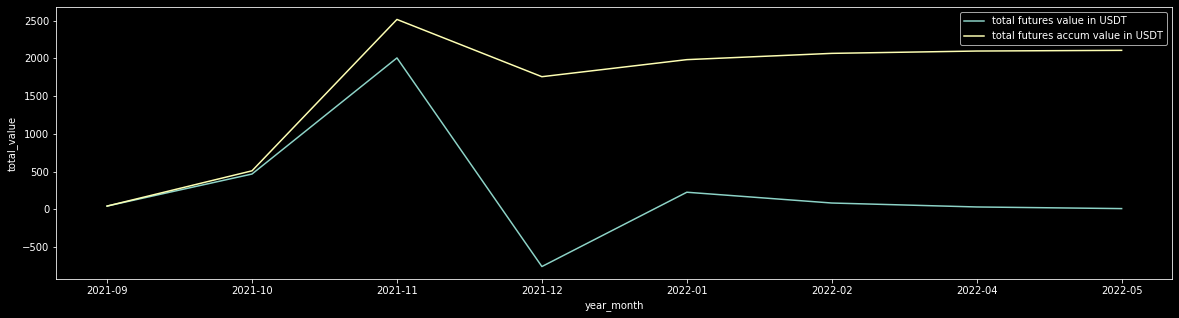

In [37]:
#plot monthly fees paid in USDT
fig = plt.figure(figsize=(20, 5))
sns.lineplot(x=join.index, y='total_value', data=join, label = 'total futures value in USDT')
sns.lineplot(x=join.index, y='total_value_accum', data=join, label = 'total futures accum value in USDT');

### futures account balance

In [38]:
df_futures['year_month'] = df_futures['UTC_Time'].dt.strftime('%Y-%m')
futures_monthly_bal = df_futures.groupby(['year_month', 'Coin']).sum()['Change'].reset_index()
futures_monthly_bal = futures_monthly_bal.pivot(index='year_month', columns='Coin', values='Change').fillna(0)
#futures_monthly_bal = futures_monthly_bal.cumsum()
futures_monthly_bal

#import month-end prices for all coins in USDT
df_hist_prices = pd.read_excel('../database/prices/historical_prices.xlsx')
df_hist_prices.set_index('datetime', inplace=True)

end_dates = []
for i in futures_monthly_bal.index:
    if i.split('-')[1] == '02':
        end_dates.append(i + '-28')
    elif i.split('-')[1] == '01' or i.split('-')[1] == '03' or i.split('-')[1] == '05' or i.split('-')[1] == '07' or i.split('-')[1] == '08' or i.split('-')[1] == '10' or i.split('-')[1] == '12':
        end_dates.append(i + '-31')
    else:
        end_dates.append(i + '-30')
monthly_prices = df_hist_prices.loc[end_dates].reset_index()
monthly_prices['datetime'] = monthly_prices['datetime'].dt.strftime('%Y-%m')
monthly_prices.set_index('datetime', inplace=True)

#join prices and balances to get value in USDT
join = futures_monthly_bal.join(monthly_prices, how='outer')
for i in futures_monthly_bal.columns:
    if i == 'USDT':
        pass
    else:
        name_price = i + 'USDT'
        join[i] = join[i] * join[name_price]
join.drop(monthly_prices.columns, axis=1, inplace=True)
join['total_value'] = join.sum(axis=1)
join['total_value_accum'] = join['total_value'].cumsum()
join

,BNB,BUSD,USDT,total_value,total_value_accum
year_month,,,,,
2021-09,0.013280,0.000000e+00,5000.000000,5000.013280,5000.013280
2021-10,-0.017926,-2.840181e-13,0.000000,-0.017926,4999.995354
2021-11,0.000000,0.000000e+00,19060.535247,19060.535247,24060.530601
2021-12,0.000000,0.000000e+00,-798.439555,-798.439555,23262.091046
2022-01,0.000000,0.000000e+00,-17423.347423,-17423.347423,5838.743623
2022-02,0.000000,0.000000e+00,-4340.217401,-4340.217401,1498.526222
2022-04,0.000000,0.000000e+00,604.752607,604.752607,2103.278829
2022-05,0.000000,0.000000e+00,-601.589111,-601.589111,1501.689718


In [40]:
funding = df_futures.loc[(df_futures['Operation'] == 'transfer_in') | (df_futures['Operation'] == 'transfer_out')]
funding['year_month'] = funding['UTC_Time'].dt.strftime('%Y-%m')
futures_inv_monthly_bal = funding.groupby(['year_month', 'Coin']).sum()['Change'].reset_index()
futures_inv_monthly_bal = futures_inv_monthly_bal.pivot(index='year_month', columns='Coin', values='Change').fillna(0)
#futures_inv_monthly_bal = futures_inv_monthly_bal.cumsum()
futures_inv_monthly_bal

#import month-end prices for all coins in USDT
df_hist_prices = pd.read_excel('../database/prices/historical_prices.xlsx')
df_hist_prices.set_index('datetime', inplace=True)

end_dates = []
for i in futures_inv_monthly_bal.index:
    if i.split('-')[1] == '02':
        end_dates.append(i + '-28')
    elif i.split('-')[1] == '01' or i.split('-')[1] == '03' or i.split('-')[1] == '05' or i.split('-')[1] == '07' or i.split('-')[1] == '08' or i.split('-')[1] == '10' or i.split('-')[1] == '12':
        end_dates.append(i + '-31')
    else:
        end_dates.append(i + '-30')
monthly_prices = df_hist_prices.loc[end_dates].reset_index()
monthly_prices['datetime'] = monthly_prices['datetime'].dt.strftime('%Y-%m')
monthly_prices.set_index('datetime', inplace=True)

#join prices and balances to get value in USDT
join_inv = futures_inv_monthly_bal.join(monthly_prices, how='outer')
for i in futures_inv_monthly_bal.columns:
    if i == 'USDT':
        pass
    else:
        name_price = i + 'USDT'
        join_inv[i] = join_inv[i] * join_inv[name_price]
join_inv.drop(monthly_prices.columns, axis=1, inplace=True)
join_inv['total_value'] = join_inv.sum(axis=1)
join_inv['total_value_accum'] = join_inv['total_value'].cumsum()
join_inv

,BNB,BUSD,USDT,total_value,total_value_accum
year_month,,,,,
2021-09,19.375,0.000000,6216.000000,6235.375000,6235.375000
2021-10,0.000,-1569.164485,4381.809200,2812.644715,9048.019715
2021-11,0.000,0.000000,14078.352028,14078.352028,23126.371742
2021-12,0.000,0.000000,-489.950096,-489.950096,22636.421646
2022-01,0.000,0.000000,6552.717139,6552.717139,29189.138785
2022-02,0.000,0.000000,-3000.000000,-3000.000000,26189.138785
2022-04,0.000,0.000000,1226.907331,1226.907331,27416.046116
2022-05,0.000,221.907154,-72.479045,149.428110,27565.474226


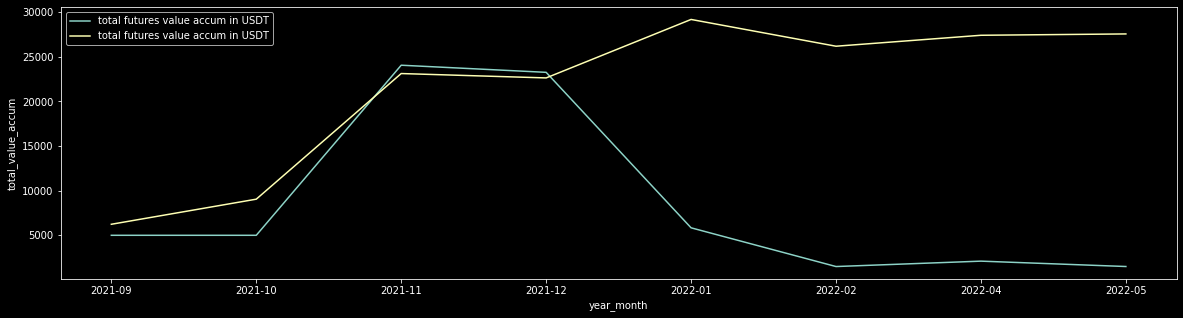

In [41]:
#plot monthly futures account value in USDT and investment in USDT
fig = plt.figure(figsize=(20, 5))
sns.lineplot(x=join.index, y='total_value_accum', data=join, label = 'total futures value accum in USDT')
sns.lineplot(x=join_inv.index, y='total_value_accum', data=join_inv, label = 'total futures value accum in USDT');